In [3]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from category_encoders import OrdinalEncoder
from xgboost import XGBClassifier
from datetime import datetime
import time
import seaborn as sns

In [4]:
df = pd.read_csv('project2.csv')
df.columns

#column 목록 확인

Index(['ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Number', 'Street',
       'Side', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

In [5]:
print(df.shape)

# data size 확인

(2845342, 47)


In [6]:
df.isnull().sum()

# 결측치 개수 확인

ID                             0
Severity                       0
Start_Time                     0
End_Time                       0
Start_Lat                      0
Start_Lng                      0
End_Lat                        0
End_Lng                        0
Distance(mi)                   0
Description                    0
Number                   1743911
Street                         2
Side                           0
City                         137
County                         0
State                          0
Zipcode                     1319
Country                        0
Timezone                    3659
Airport_Code                9549
Weather_Timestamp          50736
Temperature(F)             69274
Wind_Chill(F)             469643
Humidity(%)                73092
Pressure(in)               59200
Visibility(mi)             70546
Wind_Direction             73775
Wind_Speed(mph)           157944
Precipitation(in)         549458
Weather_Condition          70636
Amenity   

In [7]:
df.dtypes

# column별 타입 확인

ID                        object
Severity                   int64
Start_Time                object
End_Time                  object
Start_Lat                float64
Start_Lng                float64
End_Lat                  float64
End_Lng                  float64
Distance(mi)             float64
Description               object
Number                   float64
Street                    object
Side                      object
City                      object
County                    object
State                     object
Zipcode                   object
Country                   object
Timezone                  object
Airport_Code              object
Weather_Timestamp         object
Temperature(F)           float64
Wind_Chill(F)            float64
Humidity(%)              float64
Pressure(in)             float64
Visibility(mi)           float64
Wind_Direction            object
Wind_Speed(mph)          float64
Precipitation(in)        float64
Weather_Condition         object
Amenity   

In [8]:
df.describe(include="all").T

# 대략적인 데이터 프레임 모양 확인

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,2845342,2845342,A-1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Severity,2845342.0,NaN,NaN,NaN,2.137572,0.478722,1.0,2.0,2.0,2.0,4.0
Start_Time,2845342,1959333,2021-01-26 16:16:13,214,NaN,NaN,NaN,NaN,NaN,NaN,NaN
End_Time,2845342,2351505,2021-11-22 08:00:00,88,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Start_Lat,2845342.0,NaN,NaN,NaN,36.245201,5.363797,24.566027,33.445174,36.098609,40.160243,49.00058
Start_Lng,2845342.0,NaN,NaN,NaN,-97.114633,18.317819,-124.548074,-118.033113,-92.418076,-80.372431,-67.113167
End_Lat,2845342.0,NaN,NaN,NaN,36.245321,5.363873,24.566013,33.446278,36.097987,40.161049,49.075
End_Lng,2845342.0,NaN,NaN,NaN,-97.114387,18.317632,-124.545748,-118.033331,-92.417718,-80.373383,-67.109242
Distance(mi),2845342.0,NaN,NaN,NaN,0.702678,1.560361,0.0,0.052,0.244,0.764,155.186
Description,2845342,1174563,A crash has occurred causing no to minimum del...,7978,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df.nunique().sort_values(ascending=False)

# cardinality 확인

ID                       2845342
End_Time                 2351505
Start_Time               1959333
Description              1174563
Start_Lng                1120365
End_Lng                  1105404
Start_Lat                1093618
End_Lat                  1080811
Weather_Timestamp         474214
Zipcode                   363085
Street                    159651
Number                     46402
Distance(mi)               14165
City                       11681
Airport_Code                2004
County                      1707
Pressure(in)                1068
Wind_Chill(F)                897
Temperature(F)               788
Precipitation(in)            230
Wind_Speed(mph)              136
Weather_Condition            127
Humidity(%)                  100
Visibility(mi)                76
State                         49
Wind_Direction                24
Severity                       4
Timezone                       4
Side                           3
Roundabout                     2
Nautical_T

In [10]:
# - 위 데이터를 훑어보고 알아낸 점들-
#country, turning loop 카디널리티 하나 -> 제거 필요 (ㅇ)
#id는 index와 다를 바 없음 -> 제거 필요 (ㅇ)
#side가 좌우 말고 하나 더 있는듯함 -> 결측치로 판단되지만 확인 필요 -> 전방 충돌일 확률 있으니 지우지 않기로 함 (ㅇ)
#바람방향이 24개로 나옴 -> 동,서,남,북,남동,북동,북서,남서,none 9개로 줄여야 함 -> 확인해보니 variable이란게 있음 바람이 마구잡이로 부는거같아서 그건 남겨둠 (ㅇ)
#description이 카디널리티가 유독 높음 문장식으로 써져서 그런것같음 확인 필요 -> drop 하기로 함 (ㅇ)

In [11]:
#df.describe(include="all").T

In [12]:
df['Wind_Direction'].unique()

# 풍향 cardinality 많았던 부분 세부적으로 확인

array(['SW', 'Calm', 'WSW', 'WNW', 'West', 'NNW', 'South', 'W', 'NW',
       'North', 'SSE', 'SSW', 'ESE', 'SE', nan, 'East', 'Variable', 'NNE',
       'NE', 'ENE', 'CALM', 'S', 'VAR', 'N', 'E'], dtype=object)

In [13]:
df.Wind_Direction = df.Wind_Direction.replace({'SSE':'SE', 'ESE':'SE'})
df.Wind_Direction = df.Wind_Direction.replace({'ENE':'NE', 'NNE':'NE'})
df.Wind_Direction = df.Wind_Direction.replace({'NNW':'NW','WNW':'NW'})
df.Wind_Direction = df.Wind_Direction.replace({'WSW':'SW','SSW':'SW'})
df.Wind_Direction = df.Wind_Direction.replace('West','W')
df.Wind_Direction = df.Wind_Direction.replace('East','E')
df.Wind_Direction = df.Wind_Direction.replace('South','S')
df.Wind_Direction = df.Wind_Direction.replace('North','N')
df.Wind_Direction = df.Wind_Direction.replace('CALM','Calm')
df.Wind_Direction = df.Wind_Direction.replace('VAR','Variable')
df.Wind_Direction = df.Wind_Direction.fillna(df.Wind_Direction.mode()[0])

# 풍향 종류 줄이기

In [14]:
df['Wind_Direction'].unique()

# 변경 후 풍향 cardinality 확인

array(['SW', 'Calm', 'NW', 'W', 'S', 'N', 'SE', 'E', 'Variable', 'NE'],
      dtype=object)

In [15]:
df['Start_Time'] = pd.to_datetime(df['Start_Time'])
df['End_Time'] = pd.to_datetime(df['End_Time'])
df['Weather_Timestamp'] = pd.to_datetime(df['Weather_Timestamp'])
df['Acc_time'] = df.End_Time - df.Start_Time
df['Acc_time'] = round(df['Acc_time'].dt.total_seconds()/60 , 0)
df['Acc_time'].astype('int')

# 시간 관련 column datetime으로 데이터 타입 변경
# 사고 끝 시간 - 사고 시작 시간으로 사고 기간 column 생성 후 그것을 분단위로 변경 -> 시작과 기간이 있으니 끝 시간은 지워도 괜찮을듯

0          360
1          360
2          360
3          360
4          360
          ... 
2845337     29
2845338     27
2845339     28
2845340     29
2845341     29
Name: Acc_time, Length: 2845342, dtype: int32

In [16]:
(df.Weather_Timestamp - df.Start_Time).mean()

#비슷한 형식의 데이터로 보여서 차이를 확인 -> 차이가 거의 없기때문에 weather_timestamp는 지울 예정

Timedelta('0 days 00:01:11.643297838')

In [17]:
df['Side'].value_counts(normalize=True)

# 좌우뿐이 아닌 것으로 보여 확인 -> N은 neutral로 전방 충돌일거라 예상 -> 그냥 두기

R    8.270742e-01
L    1.729254e-01
N    3.514516e-07
Name: Side, dtype: float64

In [18]:
df['Description'].value_counts()

# cardinality가 너무 높아서 drop하기 전 확인 할 사항이 있나 확인 -> 지우는 게 맞는듯함

A crash has occurred causing no to minimum delays. Use caution.                                                                      7978
A crash has occurred use caution.                                                                                                    2531
An unconfirmed report of a crash has been received. Use caution.                                                                     2308
Hazardous debris is causing no to minimum delays. Use caution.                                                                       2095
At I-15 - Accident.                                                                                                                  2070
                                                                                                                                     ... 
I-895 SOUTH PAST EXIT 12 E LOMBARD ST (SB) (MM 10.6)                                                                                    1
Incident on SW 136TH ST SB near SW

In [19]:
df['Airport_Code'].value_counts()

# 근처 공항 column의 cardinality 확인 -> 일단 테스트하고 결과 보기

KCQT    52790
KMIA    45740
KORL    39380
KOPF    38556
KTMB    36250
        ...  
KHDO        1
KAXO        1
KPAT        1
KIEN        1
KICR        1
Name: Airport_Code, Length: 2004, dtype: int64

In [20]:
df['Timezone'].value_counts()

# 시간대에 이상한 cardinality나 결측치 있나 확인 -> 의외로 시간대가 정상적으로 4가지가 있음

US/Eastern     1221927
US/Pacific      967094
US/Central      488065
US/Mountain     164597
Name: Timezone, dtype: int64

In [21]:
df['Weather_Condition'].unique()

# 날씨 관련 cardinality가 왜 이렇게 높은지 의문이 들어 확인
# 겹치는 부분이 많아서 몇개로 줄일 수 있을 듯 -> 구름, 비, 많은 비, 맑음, 눈, 많은 눈, 바람, 안개 -> 바람은 다른 날씨에 부가적으로 붙어있어서 못만들 듯함

array(['Light Rain', 'Overcast', 'Mostly Cloudy', 'Snow', 'Light Snow',
       'Cloudy', nan, 'Scattered Clouds', 'Clear', 'Partly Cloudy',
       'Light Freezing Drizzle', 'Light Drizzle', 'Haze', 'Rain',
       'Heavy Rain', 'Fair', 'Drizzle', 'Fog', 'Thunderstorms and Rain',
       'Patches of Fog', 'Light Thunderstorms and Rain', 'Mist',
       'Rain Showers', 'Light Rain Showers', 'Heavy Drizzle', 'Smoke',
       'Light Freezing Fog', 'Light Freezing Rain', 'Blowing Snow',
       'Heavy Thunderstorms and Rain', 'Heavy Snow', 'Snow Grains',
       'Squalls', 'Light Fog', 'Shallow Fog', 'Thunderstorm',
       'Light Ice Pellets', 'Thunder', 'Thunder in the Vicinity',
       'Fair / Windy', 'Light Rain with Thunder',
       'Heavy Thunderstorms and Snow', 'Light Snow Showers',
       'Cloudy / Windy', 'Ice Pellets', 'N/A Precipitation',
       'Light Thunderstorms and Snow', 'T-Storm', 'Rain / Windy',
       'Wintry Mix', 'Partly Cloudy / Windy', 'Heavy T-Storm', 'Sand',
       'Ligh

In [22]:
df['Rain'] = np.where(df['Weather_Condition'].str.contains('Drizzle|Rain|storm', case=False, na = False), True, False)
df['Heavy_Rain'] = np.where(df['Weather_Condition'].str.contains('Heavy Rain|Rain Shower|Heavy T-Storm|Heavy Thunderstorms', case=False, na = False), True, False)
df['Snow'] = np.where(df['Weather_Condition'].str.contains('Snow|Sleet|Ice', case=False, na = False), True, False)
df['Heavy_Snow'] = np.where(df['Weather_Condition'].str.contains('Heavy Snow|Heavy Sleet|Heavy Ice|Snow Showers|Squalls', case=False, na = False), True, False)
df['Fog'] = np.where(df['Weather_Condition'].str.contains('Mist|Smoke|Fog|Haze|Vicinity', case=False, na = False), True, False)
df['Windy'] = np.where(df['Weather_Condition'].str.contains('Windy', case=False, na = False), True, False)
df['Clear'] = np.where(df['Weather_Condition'].str.contains('Clear|Fair', case=False, na = False), True, False)
df['Cloud'] = np.where(df['Weather_Condition'].str.contains('Cloud|Overcast', case=False, na = False), True, False)

In [23]:
df = df.drop(columns=["Country", "Turning_Loop", "ID", 'Description','Number', 'Weather_Condition'])
df = df.drop(columns=["End_Time", "End_Lat", "End_Lng", 'Weather_Timestamp', 'Wind_Chill(F)','Roundabout',
                      'Traffic_Signal','Traffic_Calming','Stop','Station','No_Exit','Railway','Junction','Give_Way',
                      'Crossing','Bump','Amenity'])
# df.Side = df.Side.fillna(df.Side.mode()[0])
# df.City = df.City.fillna(df.City.mode()[0])
# df.Street = df.Street.fillna(df.Street.mode()[0])
# df.Zipcode = df.Zipcode.fillna(df.Zipcode.mode()[0])
# df.Timezone = df.Timezone.fillna(df.Timezone.mode()[0])
df = df.dropna(subset=['Airport_Code','Sunrise_Sunset','Civil_Twilight','Nautical_Twilight','Astronomical_Twilight',
                       'Side', 'City', 'Street', 'Zipcode', 'Timezone','Wind_Speed(mph)', 'Precipitation(in)',
                       'Temperature(F)','Humidity(%)','Pressure(in)','Visibility(mi)'])
# df['Wind_Speed(mph)'] = df['Wind_Speed(mph)'].fillna(df['Wind_Speed(mph)'].mean())
# df['Precipitation(in)'] = df['Precipitation(in)'].fillna(df['Precipitation(in)'].mean())

# EDA 과정 -> nan값을 최빈이나 평균으로 채우려고했는데 데이터가 커서 그냥 다 dropna하는게 나을수도 있다고 생각함 / 과적합도 막아주는 효과?

Baseline Accuracy: 0.9283896782615626


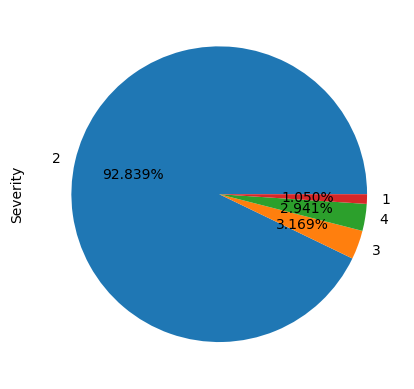

In [24]:
df['Severity'].value_counts(normalize=True).plot.pie(autopct="%.3f%%")
print("Baseline Accuracy:", df['Severity'].value_counts(normalize=True).max())

# target값 비중 시각화 -> 편중 돼있으므로 underscale아님 overscale등으로 계산 예정

In [25]:
df.isnull().sum()\

# EDA 작업 후 잔여 결측치가 있나 확인

Severity                 0
Start_Time               0
Start_Lat                0
Start_Lng                0
Distance(mi)             0
Street                   0
Side                     0
City                     0
County                   0
State                    0
Zipcode                  0
Timezone                 0
Airport_Code             0
Temperature(F)           0
Humidity(%)              0
Pressure(in)             0
Visibility(mi)           0
Wind_Direction           0
Wind_Speed(mph)          0
Precipitation(in)        0
Sunrise_Sunset           0
Civil_Twilight           0
Nautical_Twilight        0
Astronomical_Twilight    0
Acc_time                 0
Rain                     0
Heavy_Rain               0
Snow                     0
Heavy_Snow               0
Fog                      0
Windy                    0
Clear                    0
Cloud                    0
dtype: int64

In [26]:
df.shape

# 다 떨군 데이터 사이즈 확인 -> 충분

(2246017, 33)

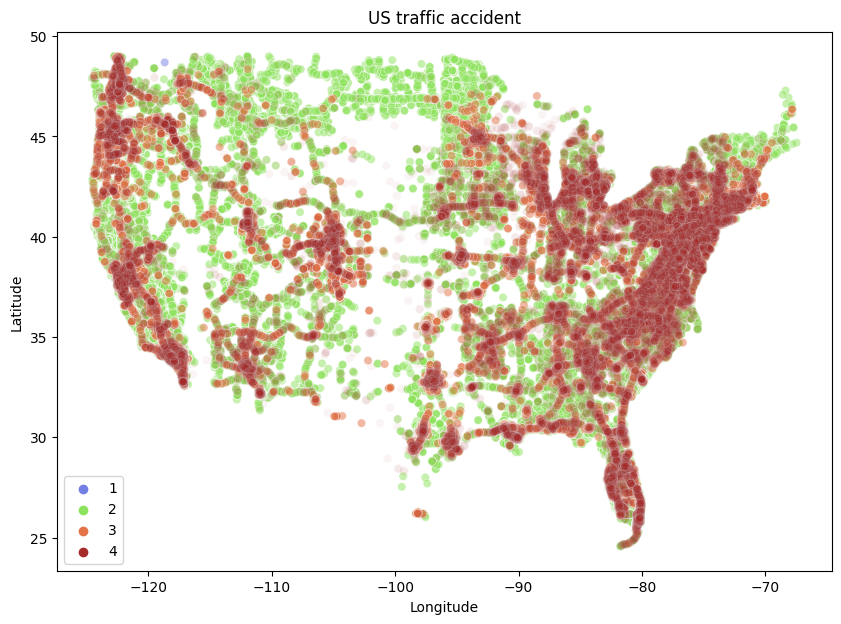

In [44]:
df1 = df[df['Severity']==1]
df2 = df[df['Severity']==2]
df3 = df[df['Severity']==3]
df4 = df[df['Severity']==4]

plt.figure(figsize=(10,7))
plt.title('US traffic accident')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

colors1 = ['#747FE3']
colors2 = ['#8EE35D']
colors3 = ['#E37346']
colors4 = ['#A52A2A']

sns.scatterplot(x = df1['Start_Lng'], y = df1['Start_Lat'], data = df1, hue = 1, palette=colors1, alpha = 0.5)
sns.scatterplot(x = df2['Start_Lng'], y = df2['Start_Lat'], data = df2, hue = 2, palette=colors2, alpha = 0.5)
sns.scatterplot(x = df3['Start_Lng'], y = df3['Start_Lat'], data = df3, hue = 3, palette=colors3, alpha = 0.5)
sns.scatterplot(x = df4['Start_Lng'], y = df4['Start_Lat'], data = df4, hue = 4, palette=colors4, alpha = 0.05)

plt.show()

In [ ]:
# target = 'Severity'

# train, val = train_test_split(df, test_size=0.2, stratify=df[target], random_state=42)
# print(train.shape, val.shape)

In [ ]:
# X_train, y_train = train.drop(columns=[target]), train[target]
# X_val, y_val = val.drop(columns=[target]), val[target]

In [ ]:
# encoder = OrdinalEncoder()
# X_train_encoded = encoder.fit_transform(X_train)
# X_val_encoded = encoder.transform(X_val)

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.pipeline import make_pipeline
# from category_encoders import OrdinalEncoder


# def get_pipeline():
#     return make_pipeline(
#         OrdinalEncoder(),
#         RandomForestClassifier(
#             n_estimators=100, random_state=42, class_weight="balanced"
#         ),
#     )


# pipe = get_pipeline()
# pipe.fit(X_train, y_train)
# print("검증 정확도", pipe.score(X_test, y_test))

In [ ]:
# model = XGBClassifier(
#     objective="binary:logistic",
#     eval_metric="auc",
#     n_estimators=987654321,
#     random_state=42,
#     n_jobs=-1,
#     max_depth=5,
#     learning_rate=0.1,
# )
# print(model)